## **GRÁFICAS DE DSC**
___

Se obtienen temperaturas y entalpías de formación asociadas a transformaciones de fases.
___

###  Se importa el sc bibliotecas necesarias
___

In [1]:
# Dependencies import
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.errors import EmptyDataError
from scipy.signal import savgol_filter
from scipy.signal import medfilt
from hampel import hampel

###  Lectura de las carpetas de trabajo y sus archivos correspondientes
___

In [2]:
# os.walk is a generator and calling next will get the first result in the form of a 3-tuple (dirpath, dirnames, filenames)
dir_name = '.'
root, dirs, files = next(os.walk(dir_name))
if '.ipynb_checkpoints' in dirs:
    dirs.remove('.ipynb_checkpoints')

# Se obtiene el indice de la lista de archivos a procesar
pos_experimental = dirs.index('experimental')
pos_blanco = dirs.index('blanco')
# Se especifica el nombre y tipo de archivo y se pasa como parámetro en la función glob para obtenter una lista de los archivos en las carpetas
files_exp = glob.glob(dirs[pos_experimental]+'\*.txt', recursive=False)
files_blanco = glob.glob(dirs[pos_blanco]+'\*.txt', recursive=False)

In [3]:
# Se guarda la lista de archivos experimentales en una variable temporal, también de tipo lista, y se muestran
tmp = files_exp
tmp2 = []
only_name_exp = []

for fnam in tmp:
    tmp2.append(fnam.rsplit('.', 1)[0])

for fnam in tmp2:
    only_name_exp.append(fnam.rsplit('\\', 1)[1])

for list_files in only_name_exp:
    print(list_files)

10° Calentamiento 5 Kmin
10° Enfriamiento
1° Calentamiento 100 Kmin
1° Calentamiento descarte
1° Enfriamiento descarte
1° Enfriamiento
2° Calentamiento 50 Kmin
2° Enfriamiento
3° Calentamiento 20 Kmin
3° Enfriamiento
4° Calentamiento 10 Kmin
4° Enfriamiento
5° Calentamiento 5 Kmin
5° Enfriamiento
6° Calentamiento 100 Kmin
6° Enfriamiento
7° Calentamiento 50 Kmin
7° Enfriamiento
8° Calentamiento 20 Kmin
8° Enfriamiento
9° Calentamiento 10 Kmin
9° Enfriamiento


In [4]:
# Se guarda la lista de archivos blanco en una variable temporal, también de tipo lista, y se muestran
tmp = files_blanco
tmp2 = []
only_name_bl = []

for fnam in tmp:
    tmp2.append(fnam.rsplit('.', 1)[0])

for fnam in tmp2:
    only_name_bl.append(fnam.rsplit('\\', 1)[1])

for list_files in only_name_bl:
    print(list_files)

10° Calentamiento 5 Kmin
10° Enfriamiento
1° Calentamiento 100 Kmin
1° Calentamiento descarte
1° Enfriamiento descarte
1° Enfriamiento
2° Calentamiento 50 Kmin
2° Enfriamiento
3° Calentamiento 20 Kmin
3° Enfriamiento
4° Calentamiento 10 Kmin
4° Enfriamiento
5° Calentamiento 5 Kmin
5° Enfriamiento
6° Calentamiento 100 Kmin
6° Enfriamiento
7° Calentamiento 50 Kmin
7° Enfriamiento
8° Calentamiento 20 Kmin
8° Enfriamiento
9° Calentamiento 10 Kmin
9° Enfriamiento


###  De los archivos leídos, se quitan las columnas de datos que no se utilizaran
___

In [5]:
# Se crea dos variables vacías de tipo lista para separar los archivos experimentales a procesar,
# reduciendo la cantidad de datos al eliminar columnas que no se procesan
good_files_exp = []
bad_files_exp = []

# Se itera sobre la variable de archivos experimentales y se separan los datos
for one_file in files_exp:
    print(f"Parsing: {one_file}")
    try:
        df = pd.read_table(one_file, encoding='UTF-16LE', skiprows=14, delim_whitespace=True, header=None)
        head = ["idx", "t", "Th", "Tm", "TG", "f"]
        df.columns = head
        df.drop('TG', inplace=True, axis=1)
        df.drop('idx', inplace=True, axis=1)
        df.drop('Th', inplace=True, axis=1)
        good_files_exp.append(df)

    except EmptyDataError:
        print(f"No columns to parse from file {one_file}")
        bad_files_exp.append(one_file)
print('Done parsing.')

Parsing: experimental\10° Calentamiento 5 Kmin.txt
Parsing: experimental\10° Enfriamiento.txt
Parsing: experimental\1° Calentamiento 100 Kmin.txt
Parsing: experimental\1° Calentamiento descarte.txt
Parsing: experimental\1° Enfriamiento descarte.txt
Parsing: experimental\1° Enfriamiento.txt
Parsing: experimental\2° Calentamiento 50 Kmin.txt
Parsing: experimental\2° Enfriamiento.txt
Parsing: experimental\3° Calentamiento 20 Kmin.txt
Parsing: experimental\3° Enfriamiento.txt
Parsing: experimental\4° Calentamiento 10 Kmin.txt
Parsing: experimental\4° Enfriamiento.txt
Parsing: experimental\5° Calentamiento 5 Kmin.txt
Parsing: experimental\5° Enfriamiento.txt
Parsing: experimental\6° Calentamiento 100 Kmin.txt
Parsing: experimental\6° Enfriamiento.txt
Parsing: experimental\7° Calentamiento 50 Kmin.txt
Parsing: experimental\7° Enfriamiento.txt
Parsing: experimental\8° Calentamiento 20 Kmin.txt
Parsing: experimental\8° Enfriamiento.txt
Parsing: experimental\9° Calentamiento 10 Kmin.txt
Parsing

In [6]:
# Se muestran los primeros 5 elementos de una tabla para evaluar la correcta separación
print(good_files_exp[0].head(5))

     t          Tm         f
0  0.2  749.537817  8.200717
1  0.4  749.534754  8.200720
2  0.6  749.531139  8.201863
3  0.8  749.527256  8.202433
4  1.0  749.522247  8.202430


In [7]:
# Se crea dos variables vacías de tipo lista para separar los archivos blanco a procesar,
# reduciendo la cantidad de datos al eliminar columnas que no se procesan
good_files_blanco = []
bad_files_blanco = []

# Se itera sobre la variable de archivos blanco y se separan los datos
for one_file in files_blanco:
    print(f"Parsing: {one_file}")
    try:
        df = pd.read_table(one_file, encoding='UTF-16LE', skiprows=14, delim_whitespace=True, header=None)
        head = ["idx", "t", "Th", "Tm", "TG", "f"]
        df.columns = head
        df.drop('TG', inplace=True, axis=1)
        df.drop('idx', inplace=True, axis=1)
        df.drop('Th', inplace=True, axis=1)
        good_files_blanco.append(df)

    except EmptyDataError:
        print(f"No columns to parse from file {one_file}")
        bad_files_blanco.append(one_file)
print('Done parsing.')

Parsing: blanco\10° Calentamiento 5 Kmin.txt
Parsing: blanco\10° Enfriamiento.txt
Parsing: blanco\1° Calentamiento 100 Kmin.txt
Parsing: blanco\1° Calentamiento descarte.txt
Parsing: blanco\1° Enfriamiento descarte.txt
Parsing: blanco\1° Enfriamiento.txt
Parsing: blanco\2° Calentamiento 50 Kmin.txt
Parsing: blanco\2° Enfriamiento.txt
Parsing: blanco\3° Calentamiento 20 Kmin.txt
Parsing: blanco\3° Enfriamiento.txt
Parsing: blanco\4° Calentamiento 10 Kmin.txt
Parsing: blanco\4° Enfriamiento.txt
Parsing: blanco\5° Calentamiento 5 Kmin.txt
Parsing: blanco\5° Enfriamiento.txt
Parsing: blanco\6° Calentamiento 100 Kmin.txt
Parsing: blanco\6° Enfriamiento.txt
Parsing: blanco\7° Calentamiento 50 Kmin.txt
Parsing: blanco\7° Enfriamiento.txt
Parsing: blanco\8° Calentamiento 20 Kmin.txt
Parsing: blanco\8° Enfriamiento.txt
Parsing: blanco\9° Calentamiento 10 Kmin.txt
Parsing: blanco\9° Enfriamiento.txt
Done parsing.


In [8]:
# Se muestran los primeros 5 elementos de una tabla para evaluar la correcta separación
print(good_files_blanco[0].head(5))

     t          Tm          f
0  0.2  749.302029 -19.257379
1  0.4  749.302147 -19.268225
2  0.6  749.300642 -19.279641
3  0.8  749.301549 -19.288209
4  1.0  749.301884 -19.295062


###  Gráficas de flujo de calor en función del tiempo
___

In [9]:
# Se crea una variable para iterar sobre los datos para crear las gráficas ΦQ (mW) vs t (s)
i = 0
for file_to_graph in good_files_exp:
    print(f"Graphing ΦQ (mW) vs t (s): {only_name_exp[i]} vs t")
    # Gráficos de flujo de calor vs temperatura de muestra
    fig1 = plt.figure(figsize=(12, 7.68))
    fig1.patch.set_facecolor("#6D9EC1")
    fig1.patch.set_alpha(0.15)

    ax = fig1.add_subplot()
    ax.patch.set_facecolor("#6D9EC1")

    ax.plot(file_to_graph.t, file_to_graph.f, linestyle='-', linewidth=0.5, color = "white", label="ΦQ")
    ax.set_ylabel('ΦQ (mW)')
    ax.set_xlabel('t (s)')
    ax.legend()

    fig1.savefig(f'graficos\{only_name_exp[i]}_vs_t.png')
    plt.close()
    i+=1
print('Done graphing.')

Graphing ΦQ (mW) vs t (s): 10° Calentamiento 5 Kmin vs t
Graphing ΦQ (mW) vs t (s): 10° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 1° Calentamiento 100 Kmin vs t
Graphing ΦQ (mW) vs t (s): 1° Calentamiento descarte vs t
Graphing ΦQ (mW) vs t (s): 1° Enfriamiento descarte vs t
Graphing ΦQ (mW) vs t (s): 1° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 2° Calentamiento 50 Kmin vs t
Graphing ΦQ (mW) vs t (s): 2° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 3° Calentamiento 20 Kmin vs t
Graphing ΦQ (mW) vs t (s): 3° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 4° Calentamiento 10 Kmin vs t
Graphing ΦQ (mW) vs t (s): 4° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 5° Calentamiento 5 Kmin vs t
Graphing ΦQ (mW) vs t (s): 5° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 6° Calentamiento 100 Kmin vs t
Graphing ΦQ (mW) vs t (s): 6° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 7° Calentamiento 50 Kmin vs t
Graphing ΦQ (mW) vs t (s): 7° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 8° Calentamiento

###  Gráficas de flujo de calor en función de la temperatura de la muestra
___

In [10]:
# Se crea una variable para iterar sobre los datos para crear las gráficas ΦQ (mW) vs T (°C)
i = 0
for file_to_graph in good_files_exp:
    print(f"Graphing ΦQ (mW) vs T (°C): {only_name_bl[i]} vs Tm")
    # Gráficos de flujo de calor vs temperatura de muestra
    fig2 = plt.figure(figsize=(12, 7.68))
    fig2.patch.set_facecolor("#6D9EC1")
    fig2.patch.set_alpha(0.15)

    ax = fig2.add_subplot()
    ax.patch.set_facecolor("#6D9EC1")

    ax.plot(file_to_graph.Tm, file_to_graph.f, linestyle='-', linewidth=0.5, color = "white", label="ΦQ")
    ax.set_ylabel('ΦQ (mW)')
    ax.set_xlabel('T (°C)')
    ax.legend()

    fig2.savefig(f'graficos\{only_name_bl[i]} vs Tm.png')
    plt.close()
    i+=1
print('Done graphing.')

Graphing ΦQ (mW) vs T (°C): 10° Calentamiento 5 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 10° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Calentamiento 100 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Calentamiento descarte vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Enfriamiento descarte vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 2° Calentamiento 50 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 2° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 3° Calentamiento 20 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 3° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 4° Calentamiento 10 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 4° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 5° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 6° Calentamiento 100 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 6° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 7° Calentamiento 50 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 7° Enfriamiento vs Tm
Graphin

###  Se sustrae el flujo de calor, de los experimentos "blanco" a los "experimental"
___

In [11]:
# Create an empty list to store your data drames
#### result containers
files_sub = []

# creamos variable para iterar
length = len(good_files_exp)
for f in range(length):
    files_sub.append(good_files_exp[f].f - good_files_blanco[f].f)

In [12]:
for f in range(length):
    print(f"Graphing ΦQ (mW) vs T (°C): {only_name_bl[f]} vs Tm")
    # Gráficos de flujo de calor vs temperatura de muestra
    fig2 = plt.figure(figsize=(12, 7.68))
    fig2.patch.set_facecolor("#6D9EC1")
    fig2.patch.set_alpha(0.15)

    ax = fig2.add_subplot()
    ax.patch.set_facecolor("#6D9EC1")

    ax.plot(good_files_exp[f].Tm, files_sub[f], linestyle='-', linewidth=0.5, color = "white", label="ΦQ")
    ax.set_ylabel('ΦQ (mW)')
    ax.set_xlabel('T (°C)')
    ax.legend()
    
    fig2.savefig(f'graficos\{only_name_bl[f]} subst vs Tm.png')
    plt.close()
    i+=1
print('Done graphing.')

Graphing ΦQ (mW) vs T (°C): 10° Calentamiento 5 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 10° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Calentamiento 100 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Calentamiento descarte vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Enfriamiento descarte vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 2° Calentamiento 50 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 2° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 3° Calentamiento 20 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 3° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 4° Calentamiento 10 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 4° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 5° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 6° Calentamiento 100 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 6° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 7° Calentamiento 50 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 7° Enfriamiento vs Tm
Graphin

###  Cálculo de derivada del flujo calórico en función del tiempo
___

### **Filtro Hampel**
Primero se eliminan los outlier mediante un filtro Hampel

In [13]:
Tm = good_files_exp[12].Tm
Y = files_sub[12]

# Hampel filter: window size (window_size=), order (order=)
window_size = 5
order = 3
Y_hampel = hampel(Y, window_size, order, imputation=True)

Graphing comparison of ΦQ (mW) vs T (°C) and his smoothed curve: 5° Calentamiento 5 Kmin vs Tm
Elimination of outliers data points with Hampel filter


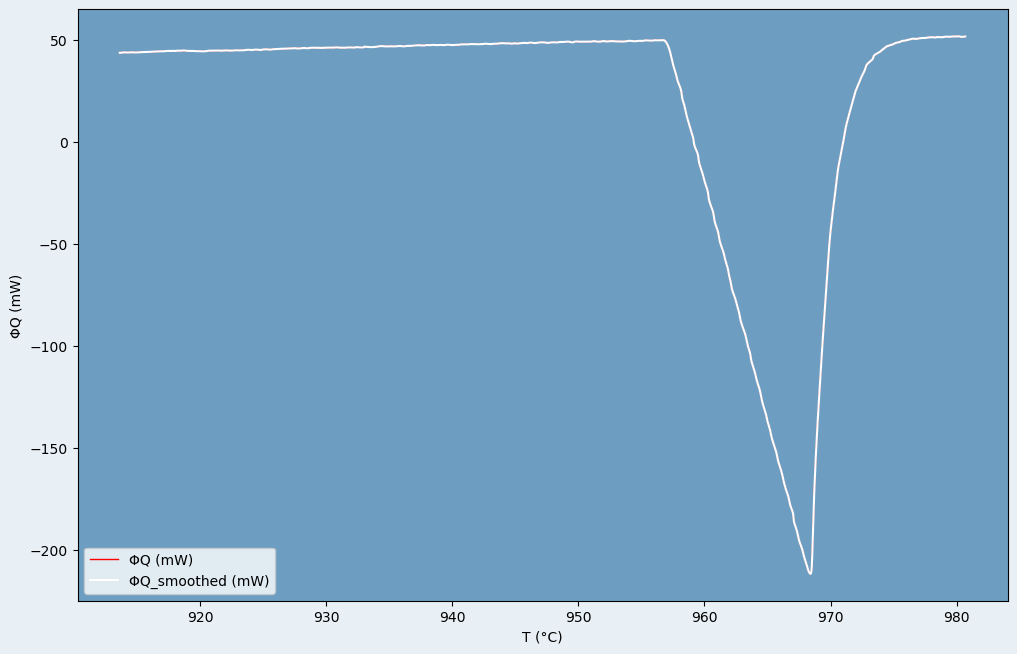

In [14]:
print(f"Graphing comparison of ΦQ (mW) vs T (°C) and his smoothed curve: {only_name_bl[12]} vs Tm")
print("Elimination of outliers data points with Hampel filter")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(Tm[10000:14000], Y[10000:14000], linestyle='-', linewidth=1.0, color = "red", label="ΦQ (mW)")
ax1.plot(Tm[10000:14000], Y_hampel[10000:14000], linestyle='-', linewidth=1.5, color = "white", label="ΦQ_smoothed (mW)")

ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

### **Primera derivada**
Método del gradiente

In [15]:
# Primera derivada
dY_dx = np.gradient(Y_hampel, Tm)

C:\Users\Pablo\anaconda3\lib\site-packages\numpy\lib\function_base.py:1239: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\Pablo\anaconda3\lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\Pablo\anaconda3\lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
C:\Users\Pablo\anaconda3\lib\site-packages\numpy\lib\function_base.py:1247: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


Graphing derivative and smoothed derivative of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Comparison with ΦQ (mW) vs T (°C) and his smoothed curve


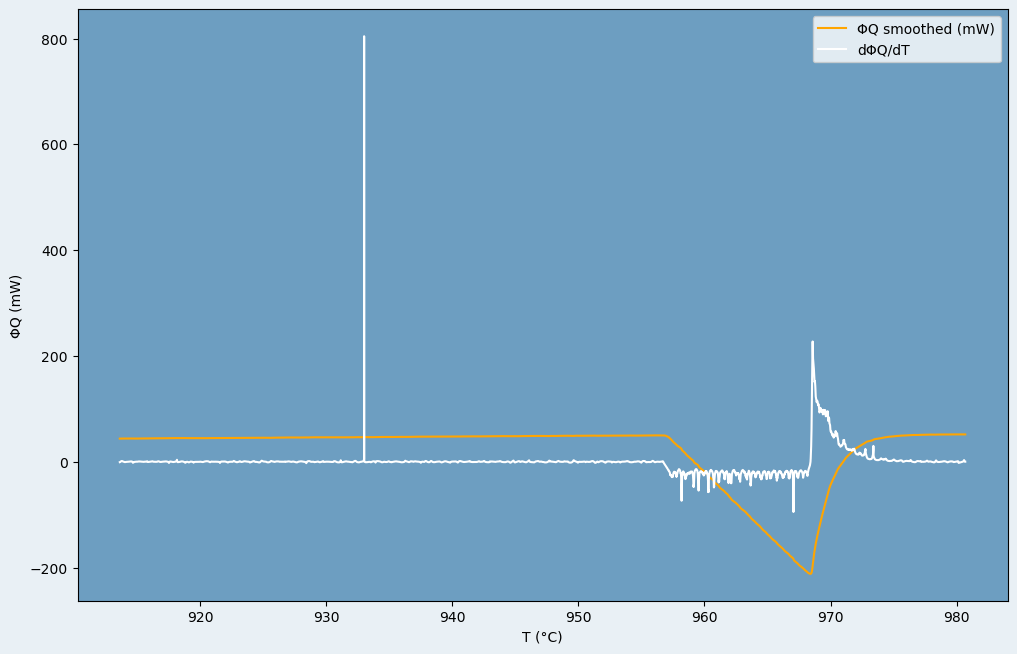

In [16]:
print(f"Graphing derivative and smoothed derivative of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
print("Comparison with ΦQ (mW) vs T (°C) and his smoothed curve")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(Tm[10000:14000], Y_hampel[10000:14000], linestyle='-', linewidth=1.5, color = "orange", label="ΦQ smoothed (mW)")
ax1.plot(Tm[10000:14000], dY_dx[10000:14000], linestyle='-', linewidth=1.5, color = "white", label="dΦQ/dT")

ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

### **Segundo filtro Hampel**
Se eliminan los outlier a la derivada discreta mediante un filtro Hampel

In [17]:
# Hampel filter: window size (window_size=), order (order=)
window_size = 50
order = 3
dY_dx_hampel = hampel(pd.Series(dY_dx), window_size, order, imputation=True)

### **Filtro Savitzky-Golay**
Suavizado final de la curva

In [18]:
# Filtro Savitzky-Golay: window size (savgol_window=), polynomial order (pol_order=)
savgol_window = 100
pol_order = 7
# smooth of Y
dY_dx_smooth = savgol_filter(dY_dx_hampel, savgol_window, pol_order)

Graphing derivative and smoothed derivative of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Comparison with ΦQ (mW) vs T (°C) and his smoothed curve


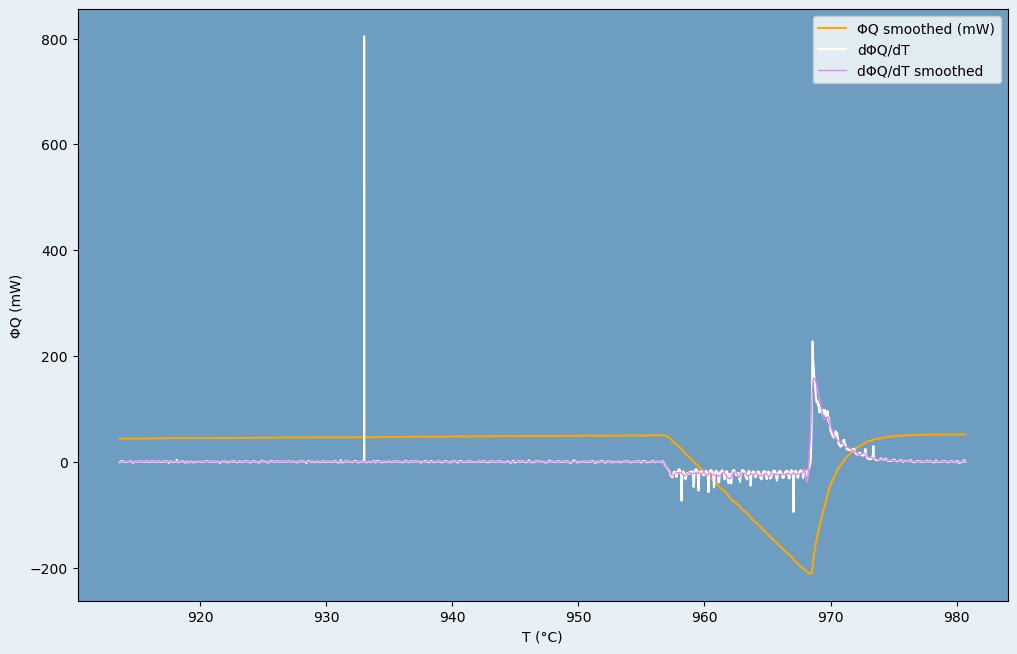

In [19]:
print(f"Graphing derivative and smoothed derivative of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
print("Comparison with ΦQ (mW) vs T (°C) and his smoothed curve")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(Tm[10000:14000], Y_hampel[10000:14000], linestyle='-', linewidth=1.5, color = "orange", label="ΦQ smoothed (mW)")
ax1.plot(Tm[10000:14000], dY_dx[10000:14000], linestyle='-', linewidth=1.5, color = "white", label="dΦQ/dT")
ax1.plot(Tm[10000:14000], dY_dx_smooth[10000:14000], linestyle='-', linewidth=1.0, color = "violet", label="dΦQ/dT smoothed")

ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

Graphing comparison of ΦQ (mW) vs T (°C) and his smoothed curve: 5° Calentamiento 5 Kmin vs Tm
Elimination of outliers data points with Hampel filter


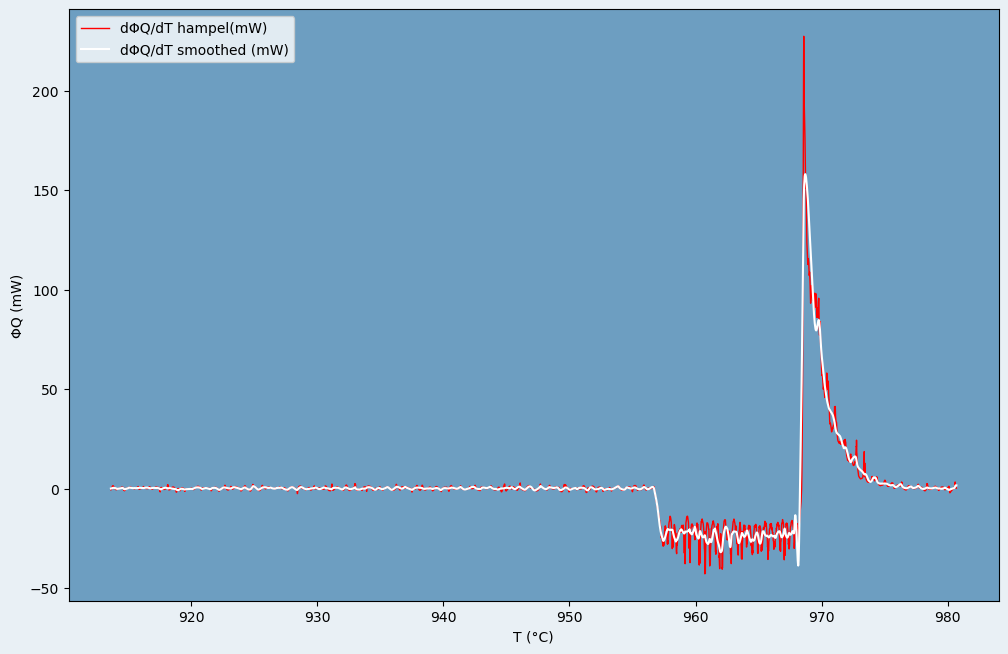

In [20]:
print(f"Graphing comparison of ΦQ (mW) vs T (°C) and his smoothed curve: {only_name_bl[12]} vs Tm")
print("Elimination of outliers data points with Hampel filter")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(Tm[10000:14000], dY_dx_hampel[10000:14000], linestyle='-', linewidth=1.0, color = "red", label="dΦQ/dT hampel(mW)")
ax1.plot(Tm[10000:14000], dY_dx_smooth[10000:14000], linestyle='-', linewidth=1.5, color = "white", label="dΦQ/dT smoothed (mW)")

ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

### **Simple Moving Average**

In [21]:
window_size = 18
# Convert array of integers to pandas series
dY_dx_series = pd.Series(dY_dx_smooth)
dY_dx_SMA = dY_dx_series.rolling(window_size, center=True).mean()

Graphing comparison of ΦQ (mW) vs T (°C) and his smoothed curve: 5° Calentamiento 5 Kmin vs Tm
Elimination of outliers data points with Hampel filter


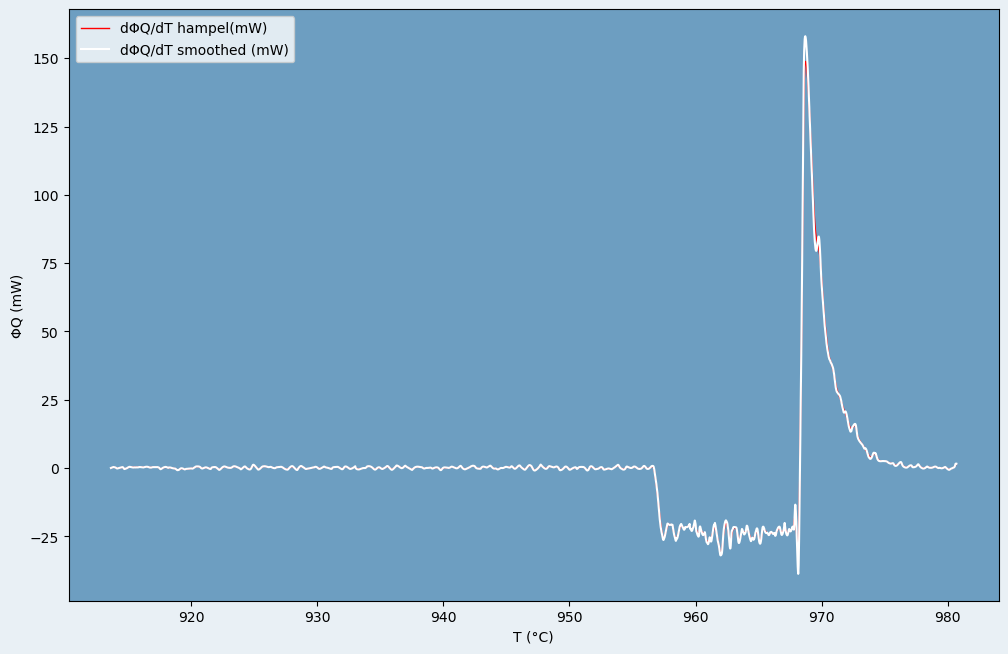

In [22]:
print(f"Graphing comparison of ΦQ (mW) vs T (°C) and his smoothed curve: {only_name_bl[12]} vs Tm")
print("Elimination of outliers data points with Hampel filter")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(Tm[10000:14000], dY_dx_SMA[10000:14000], linestyle='-', linewidth=1.0, color = "red", label="dΦQ/dT hampel(mW)")
ax1.plot(Tm[10000:14000], dY_dx_smooth[10000:14000], linestyle='-', linewidth=1.5, color = "white", label="dΦQ/dT smoothed (mW)")

ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

Median Filter and Corrected Median Filter

In [23]:
size_of__window = 21
# Median Filter
dY_dx_median = medfilt(dY_dx_SMA, size_of__window)

Median Filter types comparison

Comparison of ΦQ (mW) vs T (°C) and dΦQ/dT () vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Correction of the median filter and SMA shift


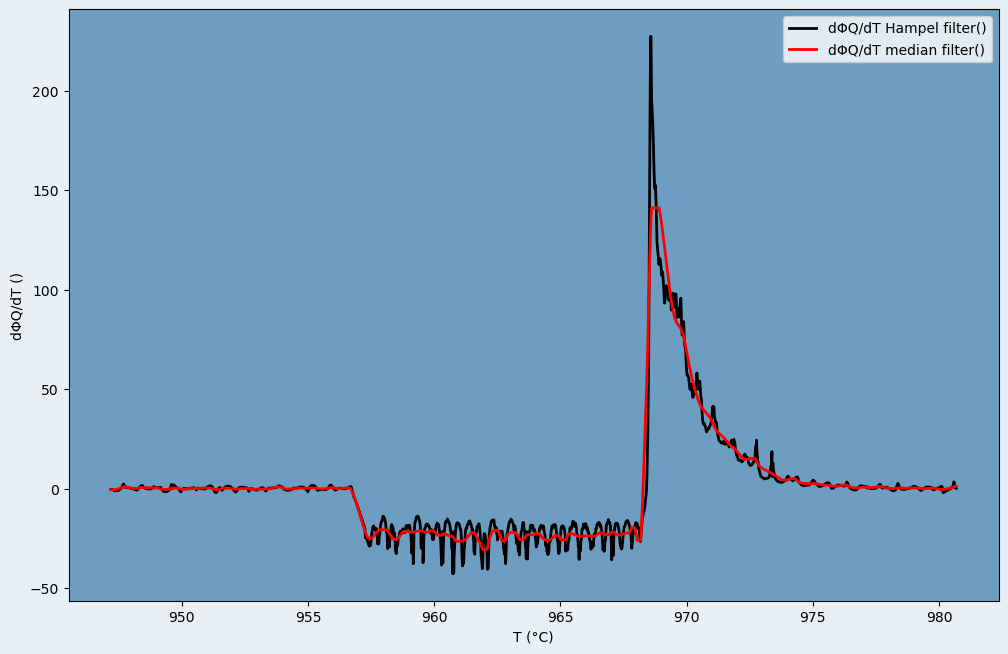

In [24]:
print(f"Comparison of ΦQ (mW) vs T (°C) and dΦQ/dT () vs T (°C): {only_name_bl[12]} vs Tm")
print("Correction of the median filter and SMA shift")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")


ax1.plot(Tm[12000:14000], dY_dx_hampel[12000:14000], linestyle='-', linewidth=2, color = "black", label="dΦQ/dT Hampel filter()")
ax1.plot(Tm[12000:14000], dY_dx_median[12000:14000], linestyle='-', linewidth=2, color = "red", label="dΦQ/dT median filter()")

ax1.set_ylabel('dΦQ/dT ()')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

Comparison of ΦQ (mW) vs T (°C) and dΦQ/dT () vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Correction of the median filter and SMA shift


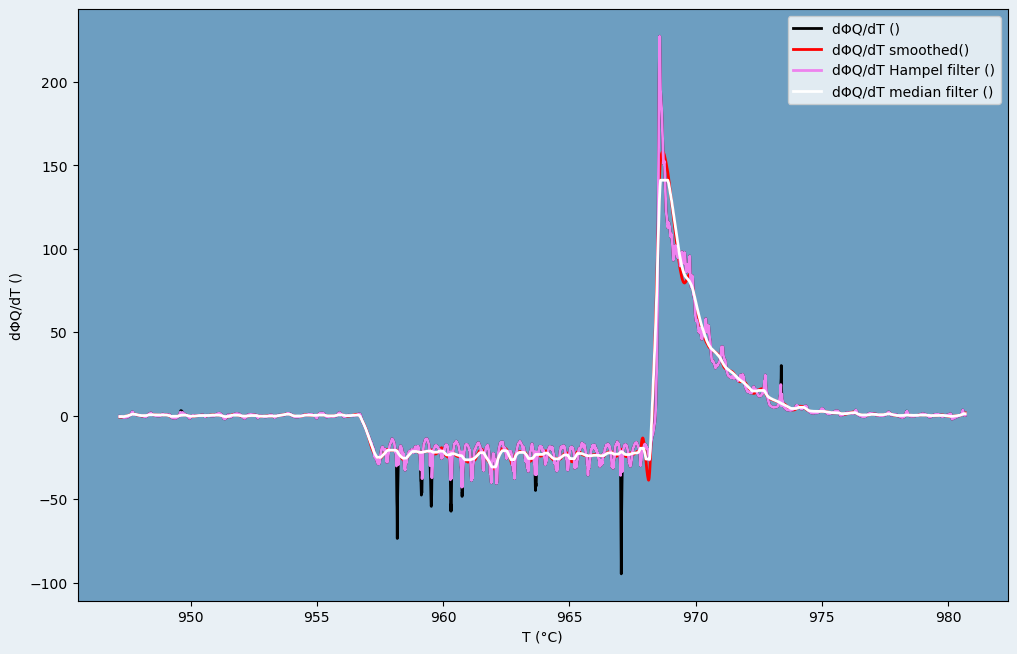

In [25]:
print(f"Comparison of ΦQ (mW) vs T (°C) and dΦQ/dT () vs T (°C): {only_name_bl[12]} vs Tm")
print("Correction of the median filter and SMA shift")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")


ax1.plot(Tm[12000:14000], dY_dx[12000:14000], linestyle='-', linewidth=2, color = "black", label="dΦQ/dT ()")
ax1.plot(Tm[12000:14000], dY_dx_smooth[12000:14000], linestyle='-', linewidth=2, color = "red", label="dΦQ/dT smoothed()")
ax1.plot(Tm[12000:14000], dY_dx_hampel[12000:14000], linestyle='-', linewidth=2, color = "violet", label="dΦQ/dT Hampel filter ()")
ax1.plot(Tm[12000:14000], dY_dx_median[12000:14000], linestyle='-', linewidth=2, color = "white", label="dΦQ/dT median filter ()")

ax1.set_ylabel('dΦQ/dT ()')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

Comparison of ΦQ (mW) vs T (°C) and dΦQ/dT () vs T (°C): 5° Calentamiento 5 Kmin vs Tm


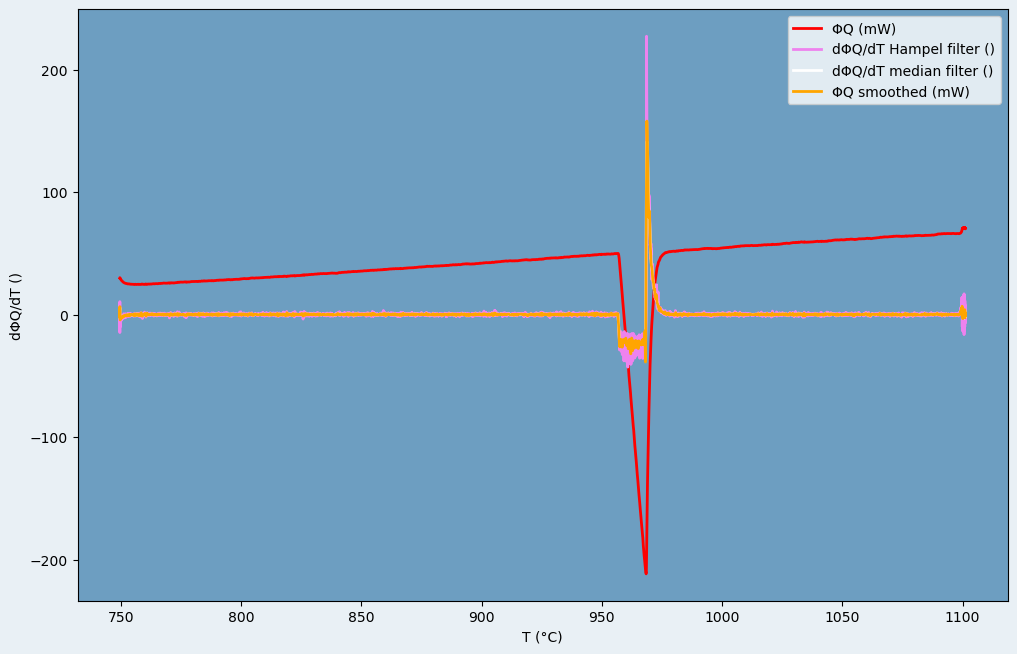

In [26]:
print(f"Comparison of ΦQ (mW) vs T (°C) and dΦQ/dT () vs T (°C): {only_name_bl[12]} vs Tm")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(Tm, Y, linestyle='-', linewidth=2, color = "red", label="ΦQ (mW)")
ax1.plot(Tm, dY_dx_hampel, linestyle='-', linewidth=2, color = "violet", label="dΦQ/dT Hampel filter ()")
ax1.plot(Tm, dY_dx_median, linestyle='-', linewidth=2, color = "white", label="dΦQ/dT median filter ()")
ax1.plot(Tm, dY_dx_smooth, linestyle='-', linewidth=2, color = "orange", label="ΦQ smoothed (mW)")

ax1.set_ylabel('dΦQ/dT ()')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

Comparison of ΦQ (mW) vs T (°C) and dΦQ/dT () vs T (°C): 5° Calentamiento 5 Kmin vs Tm


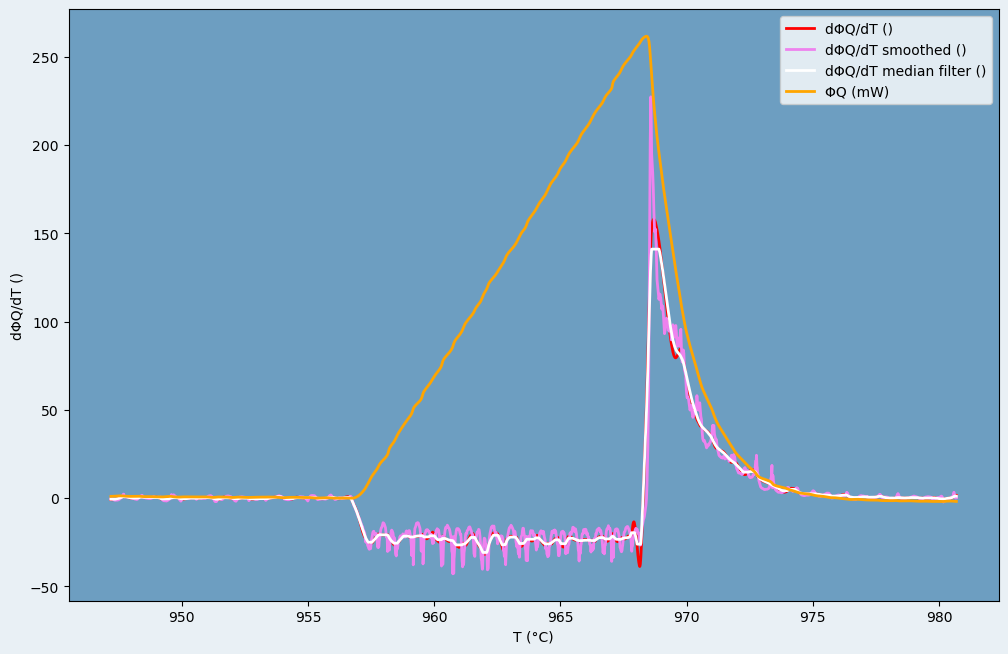

In [27]:
print(f"Comparison of ΦQ (mW) vs T (°C) and dΦQ/dT () vs T (°C): {only_name_bl[12]} vs Tm")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(Tm[12000:14000], dY_dx_smooth[12000:14000], linestyle='-', linewidth=2, color = "red", label="dΦQ/dT ()")
ax1.plot(Tm[12000:14000], dY_dx_hampel[12000:14000], linestyle='-', linewidth=2, color = "violet", label="dΦQ/dT smoothed ()")
ax1.plot(Tm[12000:14000], dY_dx_median[12000:14000], linestyle='-', linewidth=2, color = "white", label="dΦQ/dT median filter ()")
ax1.plot(Tm[12000:14000], Y[12000:14000]*-1+50, linestyle='-', linewidth=2, color = "orange", label="ΦQ (mW)")

ax1.set_ylabel('dΦQ/dT ()')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

Comparison of ΦQ (mW) vs T (°C) and dΦQ/dT () vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Transformation Max Point


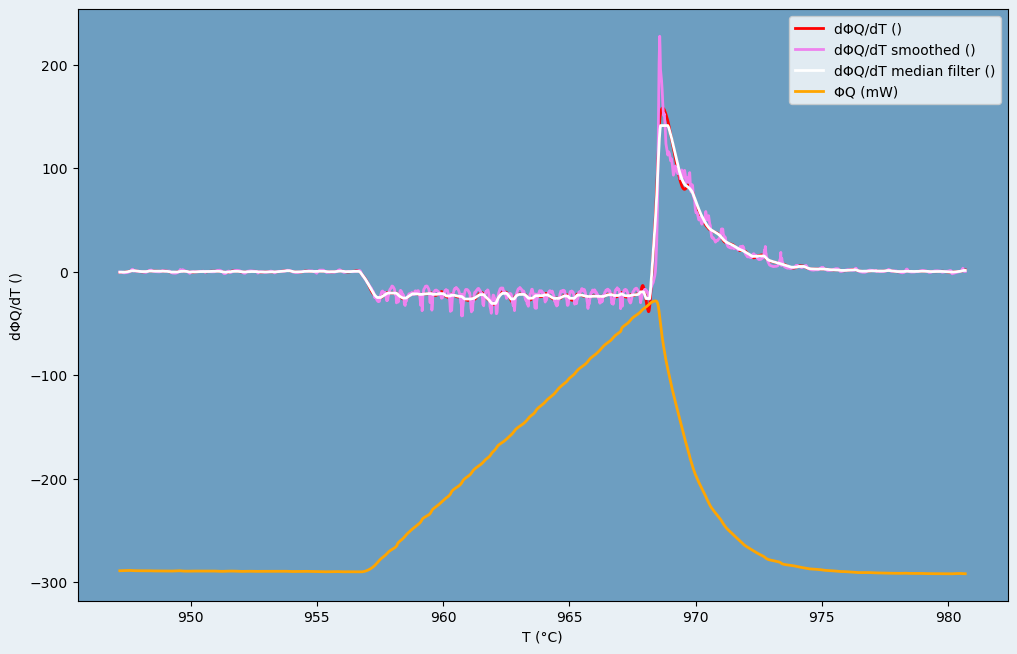

In [28]:
print(f"Comparison of ΦQ (mW) vs T (°C) and dΦQ/dT () vs T (°C): {only_name_bl[12]} vs Tm")
print("Transformation Max Point")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(Tm[12000:14000], dY_dx_smooth[12000:14000], linestyle='-', linewidth=2, color = "red", label="dΦQ/dT ()")
ax1.plot(Tm[12000:14000], dY_dx_hampel[12000:14000], linestyle='-', linewidth=2, color = "violet", label="dΦQ/dT smoothed ()")
ax1.plot(Tm[12000:14000], dY_dx_median[12000:14000], linestyle='-', linewidth=2, color = "white", label="dΦQ/dT median filter ()")
ax1.plot(Tm[12000:14000], Y[12000:14000]*-1-240, linestyle='-', linewidth=2, color = "orange", label="ΦQ (mW)")

ax1.set_ylabel('dΦQ/dT ()')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

Calculus of the second derivative

In [29]:
# second derivative
ddY_dx2 = pd.Series(np.gradient(dY_dx_hampel, Tm))

# Hampel filter: window size (window_size=), order (order=)
window_size = 11
order = 3

ddY_dx2_hampel = hampel(ddY_dx2, window_size, order, imputation=True)

C:\Users\Pablo\anaconda3\lib\site-packages\numpy\lib\function_base.py:1239: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\Pablo\anaconda3\lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\Pablo\anaconda3\lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))


Graphing smoothed second derivative and of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Comparison with ddΦQ/dT2 (mW) vs T (°C) and his smoothed curve


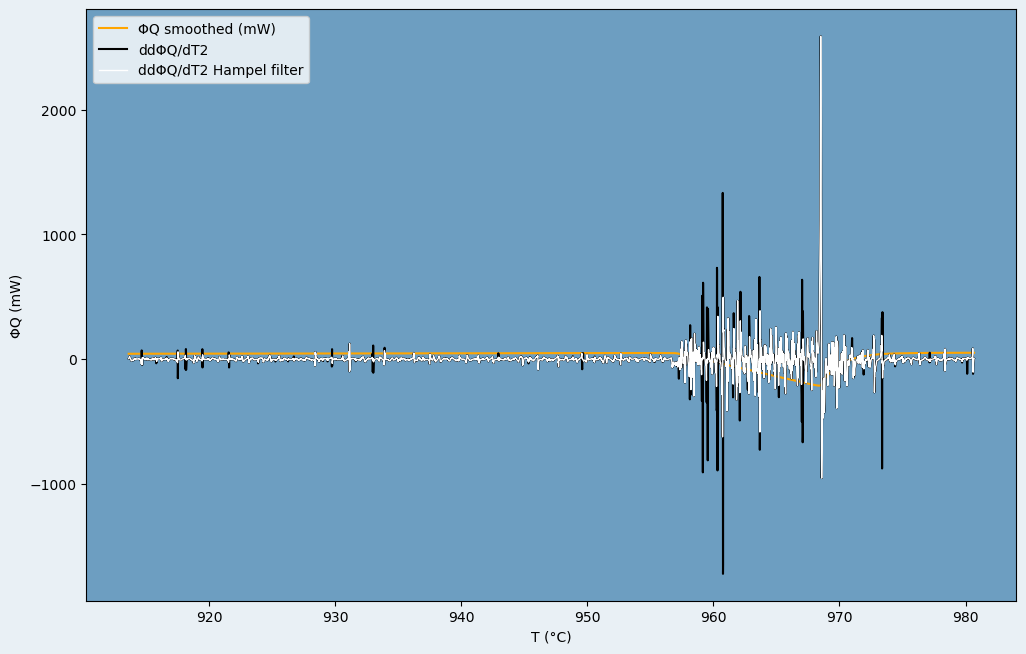

In [30]:
print(f"Graphing smoothed second derivative and of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
print("Comparison with ddΦQ/dT2 (mW) vs T (°C) and his smoothed curve")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(Tm[10000:14000], Y_hampel[10000:14000], linestyle='-', linewidth=1.5, color = "orange", label="ΦQ smoothed (mW)")
ax1.plot(Tm[10000:14000], ddY_dx2[10000:14000], linestyle='-', linewidth=1.5, color = "black", label="ddΦQ/dT2")
ax1.plot(Tm[10000:14000], ddY_dx2_hampel[10000:14000], linestyle='-', linewidth=1.0, color = "white", label="ddΦQ/dT2 Hampel filter")

ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

Graphing smoothed second derivative and of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Comparison with ddΦQ/dT2 (mW) vs T (°C) and his smoothed curve


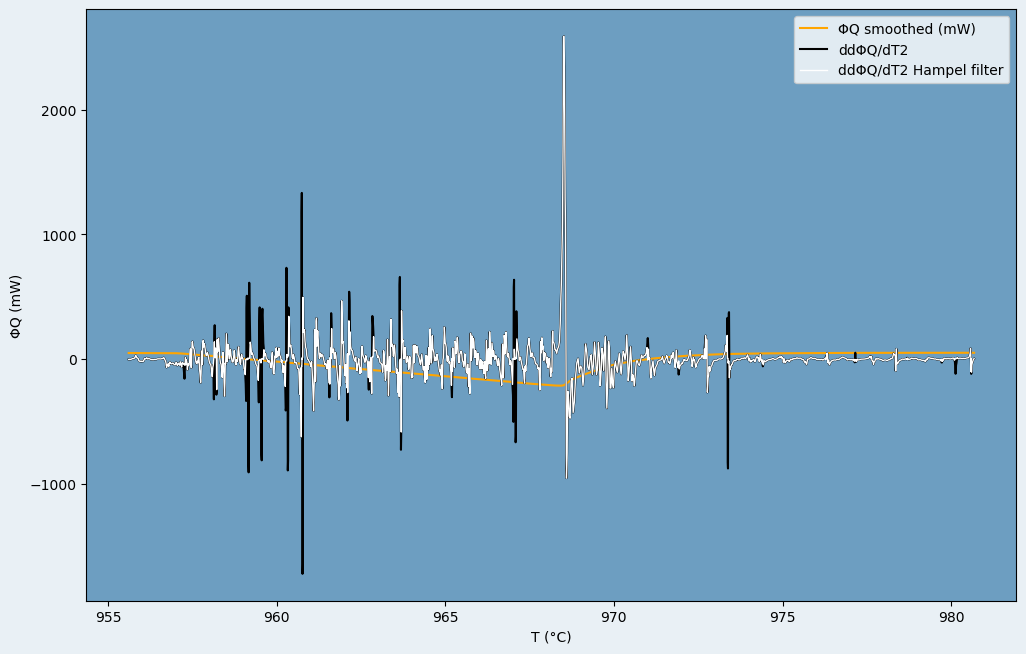

In [31]:
print(f"Graphing smoothed second derivative and of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
print("Comparison with ddΦQ/dT2 (mW) vs T (°C) and his smoothed curve")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(Tm[12500:14000], Y_hampel[12500:14000], linestyle='-', linewidth=1.5, color = "orange", label="ΦQ smoothed (mW)")
ax1.plot(Tm[12500:14000], ddY_dx2[12500:14000], linestyle='-', linewidth=1.5, color = "black", label="ddΦQ/dT2")
ax1.plot(Tm[12500:14000], ddY_dx2_hampel[12500:14000], linestyle='-', linewidth=1.0, color = "white", label="ddΦQ/dT2 Hampel filter")

ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

Simple Moving Average

In [32]:
window_size = 15
# Convert array of integers to pandas series
ddY_dx2_series = pd.Series(ddY_dx2_hampel)
ddY_dx2_SMA = ddY_dx2_series.rolling(window_size, center=True).mean()

Median Filter and Corrected Median Filter

In [33]:
size_of__window = 21
# Median Filter
ddY_dx2_median = medfilt(ddY_dx2_SMA, size_of__window)

Median Filter comparison

Graphing smoothed second derivative and of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Comparison with ddΦQ/dT2 (mW) vs T (°C) and his smoothed curve


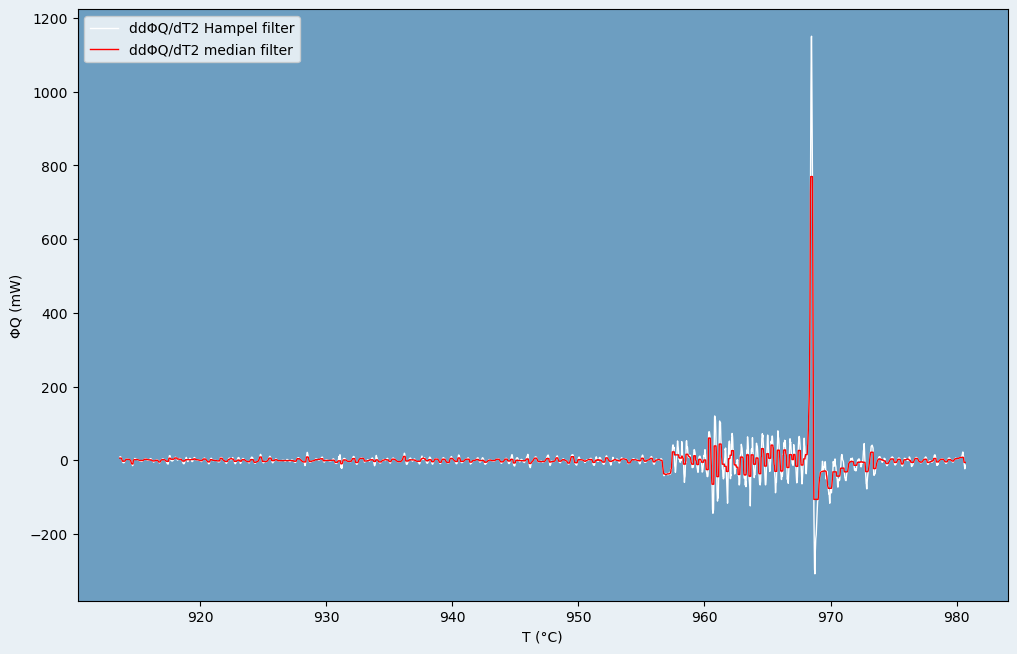

In [34]:
print(f"Graphing smoothed second derivative and of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
print("Comparison with ddΦQ/dT2 (mW) vs T (°C) and his smoothed curve")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(Tm[10000:14000], ddY_dx2_SMA[10000:14000], linestyle='-', linewidth=1.0, color = "white", label="ddΦQ/dT2 Hampel filter")
ax1.plot(Tm[10000:14000], ddY_dx2_median[10000:14000], linestyle='-', linewidth=1.0, color = "red", label="ddΦQ/dT2 median filter")

ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

Graphing smoothed second derivative and of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Comparison with ddΦQ/dT2 (mW) vs T (°C) and his smoothed curve


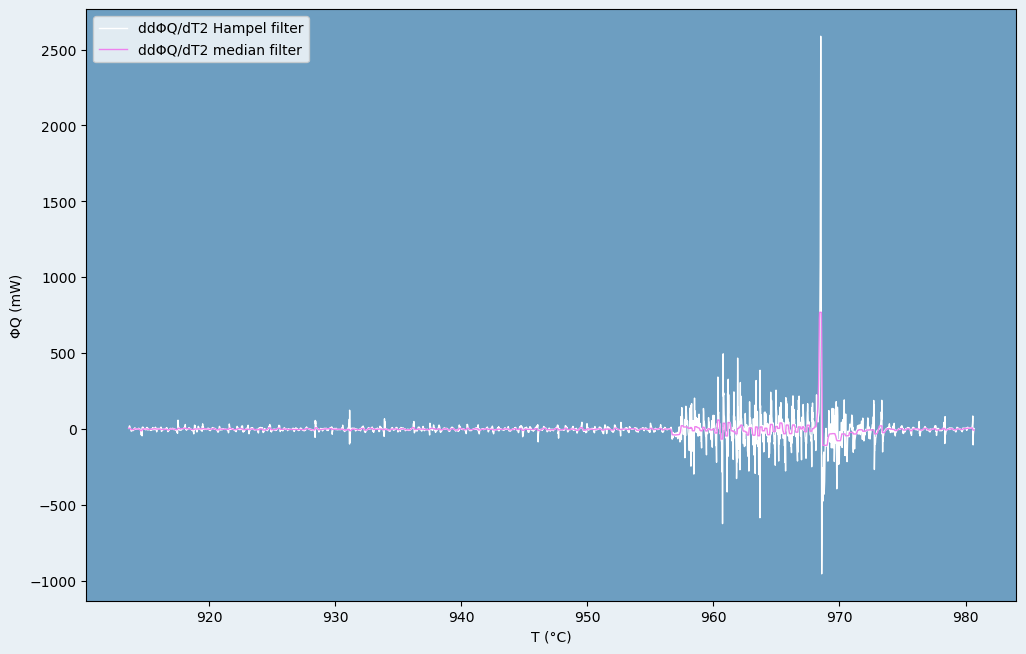

In [35]:
print(f"Graphing smoothed second derivative and of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
print("Comparison with ddΦQ/dT2 (mW) vs T (°C) and his smoothed curve")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(Tm[10000:14000], ddY_dx2_hampel[10000:14000], linestyle='-', linewidth=1.0, color = "white", label="ddΦQ/dT2 Hampel filter")
ax1.plot(Tm[10000:14000], ddY_dx2_median[10000:14000], linestyle='-', linewidth=1.0, color = "violet", label="ddΦQ/dT2 median filter")

ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

### **Mínimos y Máximos**

Se comprueba que tengan las mismas dimensiones

In [36]:
print(dY_dx_hampel.shape, dY_dx_median.shape, Y_hampel.shape)
print(ddY_dx2_median.shape, ddY_dx2_hampel.shape, ddY_dx2.shape)

(22500,) (22500,) (22500,)
(22500,) (22500,) (22500,)


Si hay NaN se reemplaza por cero

In [37]:
Y_hampel[np.isnan(Y_hampel)] = 0
# Primera derivada
dY_dx_hampel[np.isnan(dY_dx_hampel)] = 0
dY_dx_median[np.isnan(dY_dx_median)] = 0
# Segunda derivada
ddY_dx2[np.isnan(ddY_dx2)] = 0
ddY_dx2_hampel[np.isnan(ddY_dx2_hampel)] = 0
ddY_dx2_median[np.isnan(ddY_dx2_median)] = 0

In [38]:
print(pd.Series(ddY_dx2).count(), pd.Series(ddY_dx2_hampel).count(), pd.Series(ddY_dx2_median).count())
print(pd.Series(dY_dx_hampel).count(), pd.Series(dY_dx_median).count(), pd.Series(Y_hampel).count())

22500 22500 22500
22500 22500 22500


Se registran los cambios de signo, los cruces por cero en la primera y segunda derivada

In [39]:
asign = np.sign(dY_dx_median)
dY_dx_sign = ((np.roll(asign, 1) - asign) != 0).astype(int)

asign = np.sign(ddY_dx2_median)
ddY_dx2_sign = ((np.roll(asign, 1) - asign) != 0).astype(int)

Se comprueba la cantidad

In [40]:
print(np.count_nonzero(dY_dx_sign))
print(np.count_nonzero(ddY_dx2_sign))

527
1002


Change zeros to NaN to graph printing

In [41]:
dY_dx_with_NaN = dY_dx_sign
dY_dx_with_NaN = dY_dx_with_NaN.astype('float')
dY_dx_with_NaN[dY_dx_sign == 0] = 'nan'

ddY_dx2_with_NaN = ddY_dx2_sign
ddY_dx2_with_NaN = ddY_dx2_with_NaN.astype('float')
ddY_dx2_with_NaN[ddY_dx2_sign == 0] = 'nan'

Graphing smoothed second derivative of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Adding the crossing zero points of data obtained from the second derivative


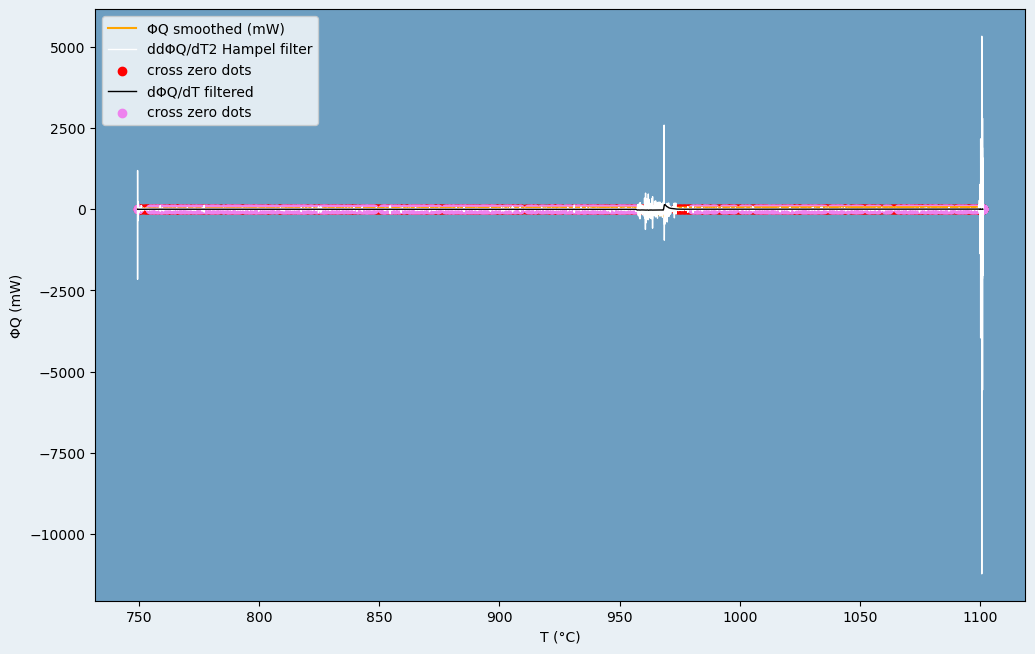

In [42]:
print(f"Graphing smoothed second derivative of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
print("Adding the crossing zero points of data obtained from the second derivative")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(Tm, Y_hampel, linestyle='-', linewidth=1.5, color = "orange", label="ΦQ smoothed (mW)")
ax1.plot(Tm, ddY_dx2_hampel, linestyle='-', linewidth=1.0, color = "white", label="ddΦQ/dT2 Hampel filter")
ax1.scatter(Tm, ddY_dx2_with_NaN, color = "red", label="cross zero dots")
ax1.plot(Tm, dY_dx_median, linestyle='-', linewidth=1.0, color = "black", label="dΦQ/dT filtered")
ax1.scatter(Tm, dY_dx_with_NaN, color = "violet", label="cross zero dots")


ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

Graphing smoothed second derivative of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Adding the crossing zero points of data obtained from the second derivative


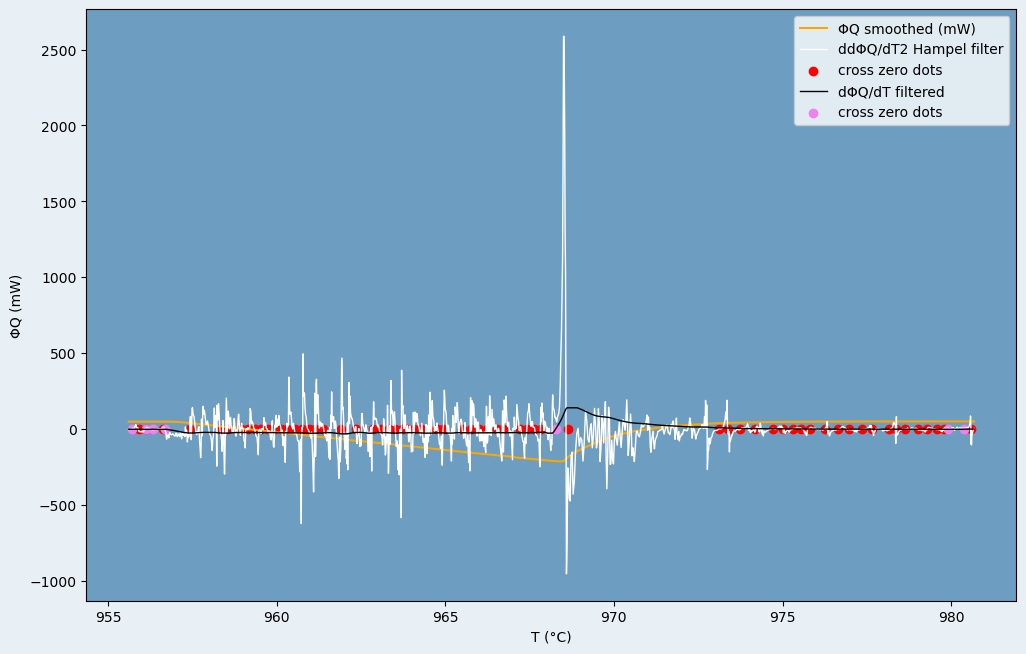

In [43]:
print(f"Graphing smoothed second derivative of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
print("Adding the crossing zero points of data obtained from the second derivative")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(Tm[12500:14000], Y_hampel[12500:14000], linestyle='-', linewidth=1.5, color = "orange", label="ΦQ smoothed (mW)")
ax1.plot(Tm[12500:14000], ddY_dx2_hampel[12500:14000], linestyle='-', linewidth=1.0, color = "white", label="ddΦQ/dT2 Hampel filter")
ax1.scatter(Tm[12500:14000], ddY_dx2_with_NaN[12500:14000], color = "red", label="cross zero dots")
ax1.plot(Tm[12500:14000], dY_dx_median[12500:14000], linestyle='-', linewidth=1.0, color = "black", label="dΦQ/dT filtered")
ax1.scatter(Tm[12500:14000], dY_dx_with_NaN[12500:14000], color = "violet", label="cross zero dots")


ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend()
plt.show()

Se eliminan los datos que introducen ruido, luego de cambios en la velocidad de calentamiento / enfriamiento o previo y posterior a condiciones estáticas

In [44]:
df = pd.DataFrame({'Tm': pd.Series(Tm), 'dY_dx': pd.Series(dY_dx_median)})
size_ = df.shape[0]
print(size_)
# Drop first 3 rows of dataframe
N = int(size_ * 0.1)
df.drop(index=df.index[:N], inplace=True)
# Check size
print(df.shape[0])

22500
20250


In [45]:
df1 = df
size_ = df1.shape[0]
print(size_)
# Drop first 3 rows of dataframe
N = int(size_ * 0.9)
df1.drop(index=df1.index[N:], inplace=True)
# Check size
print(df1.shape[0])

20250
18225


In [46]:
df1.Tm

2250      783.753641
2251      783.768368
2252      783.782037
2253      783.797113
2254      783.810477
            ...     
20470    1089.581209
20471    1089.594780
20472    1089.609985
20473    1089.624832
20474    1089.638150
Name: Tm, Length: 18225, dtype: float64

In [47]:
Tm_reduced = df1.Tm
window_size = 20
# Convert array of integers to pandas series
dY_dx_df_SMA = df1.dY_dx.rolling(window_size, center=True).mean()

Graphing smoothed first derivative of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm


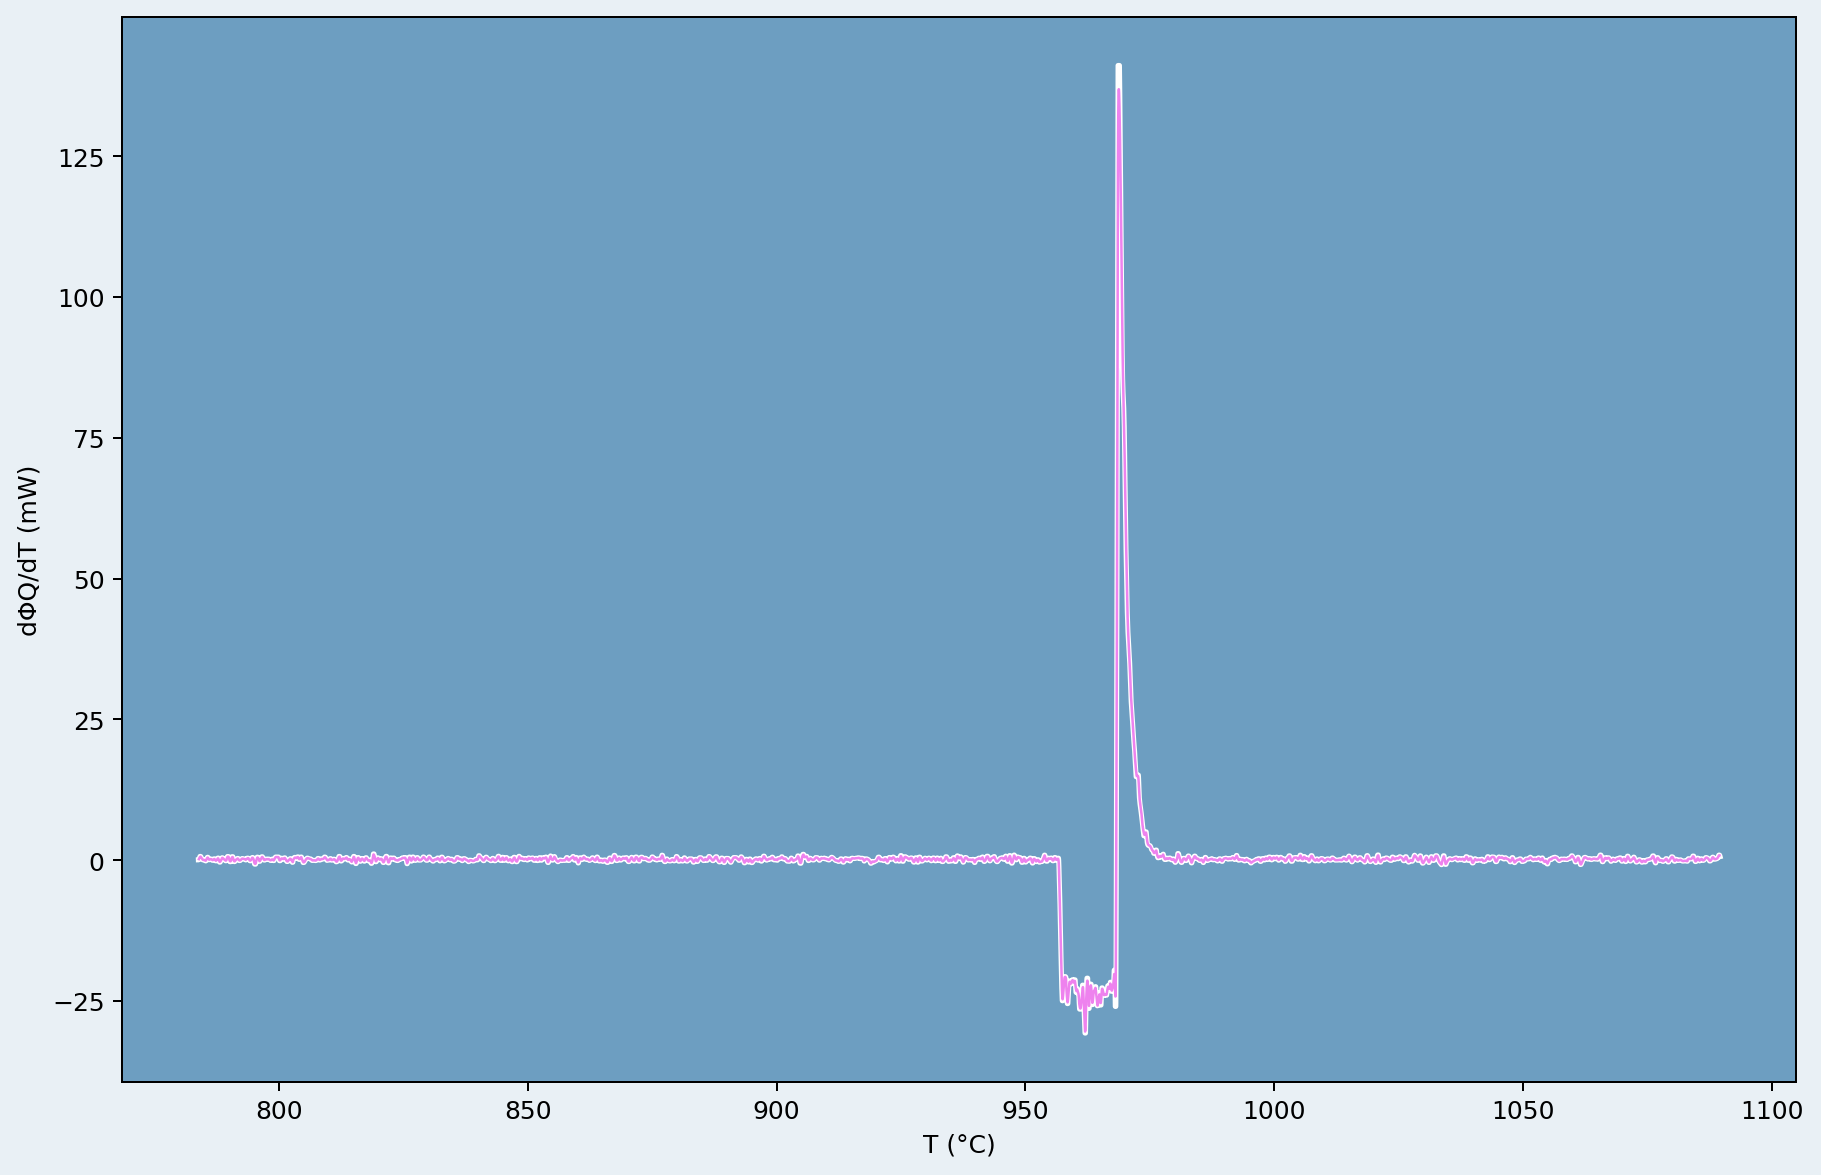

In [48]:
print(f"Graphing smoothed first derivative of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68), dpi= 180)
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

plt.plot(Tm_reduced, df1.dY_dx, color="white", lw=2)
plt.plot(Tm_reduced, dY_dx_df_SMA, color="violet", lw=1)

ax1.set_ylabel('dΦQ/dT (mW)')
ax1.set_xlabel('T (°C)')
plt.show()

Graphing smoothed first derivative of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Median with high and low envelopes


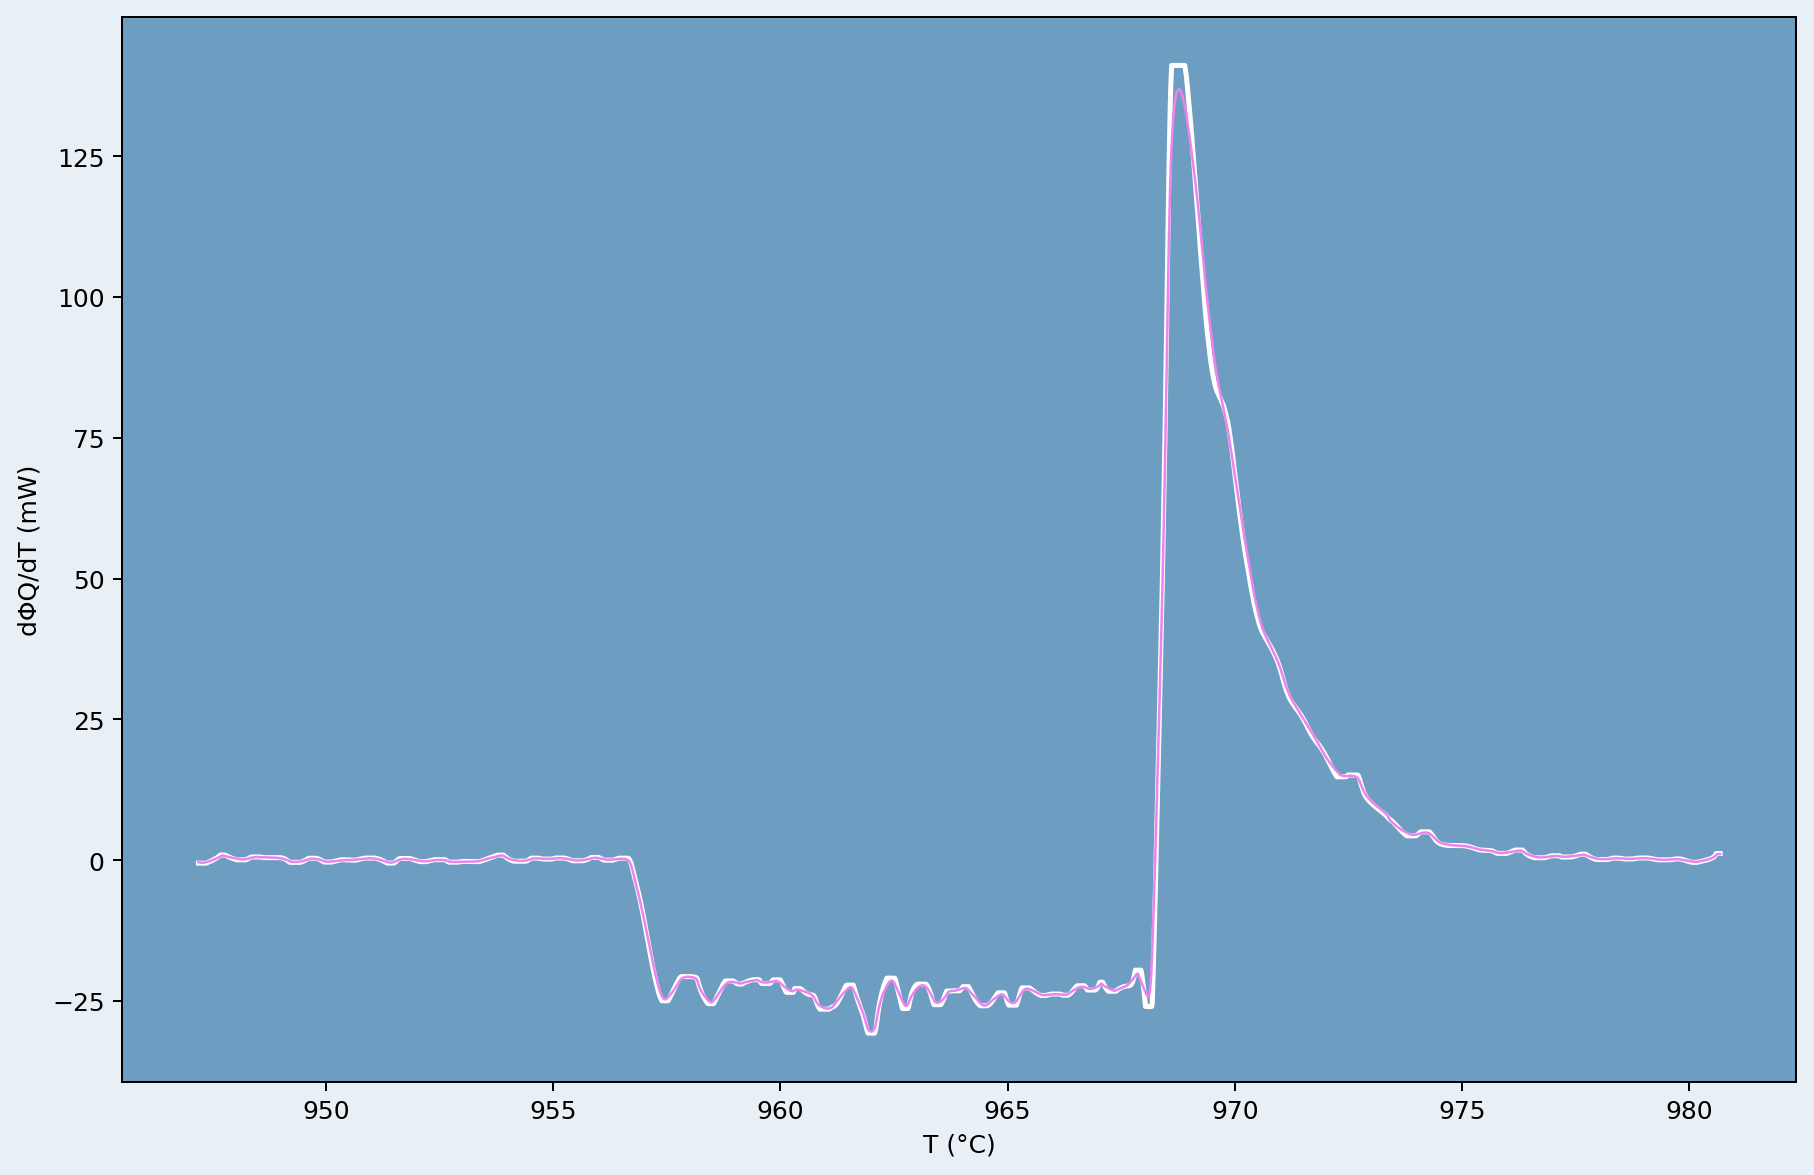

In [49]:
print(f"Graphing smoothed first derivative of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
print("Median with high and low envelopes")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68), dpi= 180)
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

plt.plot(Tm_reduced[9750:11750], df1.dY_dx[9750:11750], color="white", lw=2)
plt.plot(Tm_reduced[9750:11750], dY_dx_df_SMA[9750:11750], color="violet", lw=1)

ax1.set_ylabel('dΦQ/dT (mW)')
ax1.set_xlabel('T (°C)')
plt.show()

In [50]:
rango = dY_dx_df_SMA.to_numpy().size-window_size
print(rango, rango+window_size, dY_dx_df_SMA.size, dY_dx_median.size)

18205 18225 18225 22500


In [51]:
dY_dx_sd = np.zeros(dY_dx_median.size)
dY_dx_m = np.zeros(dY_dx_median.size)

print(dY_dx_m.size, dY_dx_sd.size)

22500 22500


In [52]:
for i in range(rango):
    dY_dx_m[i] = dY_dx_median[i+window_size]
    #dY_dx_sd[i] = dY_dx_median[i:window_size]
dY_dx_high = dY_dx_df_median + s
dY_dx_low = dY_dx_df_median - s
print(dY_dx_m.size, dY_dx_df_SMA.size, dY_dx_median.size)

NameError: name 'dY_dx_df_median' is not defined

In [ ]:
for i in range(rango):
    dY_dx_high[i] = dY_dx_df_median[i+s]

In [ ]:
print(f"Graphing smoothed first derivative of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
print("Median with high and low envelopes")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68), dpi= 180)
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

plt.plot(Tm_reduced, dY_dx_df_SMA, color="white", lw=2)
plt.plot(Tm_reduced, dY_dx_high, color="violet", lw=1)
#plt.fill_between(Tm_reduced, dY_dx_low, dY_dx_high, color="#3F5D7D")


ax1.set_ylabel('dΦQ/dT (mW)')
ax1.set_xlabel('T (°C)')
plt.show()